Cell 1: Import Required Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import numpy as np 

sns.set(style="whitegrid")
os.makedirs("../outputs/plots", exist_ok=True)

Load Cleaned DataFrames

In [ ]:
age_cy_clean = joblib.load("../data/cleaned/age_cy_clean.pkl")
age_12mo_clean = joblib.load("../data/cleaned/age_12mo_clean.pkl")
race_cy_clean = joblib.load("../data/cleaned/race_cy_clean.pkl")
race_12mo_clean = joblib.load("../data/cleaned/race_12mo_clean.pkl")
gender_cy_clean = joblib.load("../data/cleaned/gender_cy_clean.pkl")
gender_12mo_clean = joblib.load("../data/cleaned/gender_12mo_clean.pkl")

# 🔍 Filter out 'All' from LOCATION_ID to avoid invalid aggregations
dataframes = [age_cy_clean, age_12mo_clean, race_cy_clean, race_12mo_clean, gender_cy_clean, gender_12mo_clean]
for i, df in enumerate(dataframes):
    dataframes[i] = df[df["LOCATION_ID"] != "All"]

age_cy_clean, age_12mo_clean, race_cy_clean, race_12mo_clean, gender_cy_clean, gender_12mo_clean = dataframes

print("✅ DataFrames loaded.")
display(age_cy_clean.head())




✅ DataFrames loaded.


,CALENDAR_YEAR,LOCATION_ID,LOCATION,AGE_GROUP_PUBLIC,HOMELESS_COUNT,UNIQUE_ID
9,2017,CA-500,Santa Clara County CoC,18-24,775,CA-500_2017
10,2017,CA-500,Santa Clara County CoC,25-34,1501,CA-500_2017
11,2017,CA-500,Santa Clara County CoC,35-44,1436,CA-500_2017
12,2017,CA-500,Santa Clara County CoC,45-54,1635,CA-500_2017
13,2017,CA-500,Santa Clara County CoC,55-64,1497,CA-500_2017


Define General Demographic Plot Function

In [ ]:
def plot_trend(df, group_col, title, filename=None, max_categories=8, palette="Set2"):
    df = df.copy()
    df["HOMELESS_COUNT"] = pd.to_numeric(df["HOMELESS_COUNT"], errors="coerce")
    grouped = df.groupby(["CALENDAR_YEAR", group_col])["HOMELESS_COUNT"].sum().reset_index()
    totals = grouped.groupby(group_col)["HOMELESS_COUNT"].sum().reset_index()
    totals = totals.dropna(subset=["HOMELESS_COUNT"])
    top_categories = totals.nlargest(max_categories, "HOMELESS_COUNT")[group_col]
    grouped = grouped[grouped[group_col].isin(top_categories)]

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=grouped, x="CALENDAR_YEAR", y="HOMELESS_COUNT", hue=group_col, marker="o", linewidth=2, palette=palette)
    plt.title(title, fontsize=16, weight="bold")
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Total Homeless Count", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(title=group_col.replace("_", " ").title(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    if filename:
        path = f"../outputs/plots/{filename}.png"
        plt.savefig(path, dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved to: {path}")

    plt.show()




Filter Race Data for "Alone" Responses

In [ ]:

race_cy_filtered = race_cy_clean[race_cy_clean["RACE_COMBO"].str.lower().str.strip() == "alone"]
race_12mo_filtered = race_12mo_clean[race_12mo_clean["RACE_COMBO"].str.lower().str.strip() == "race alone"]




Plot Demographic Trends

✅ Plot saved to: ../outputs/plots/age_trend_cy.png


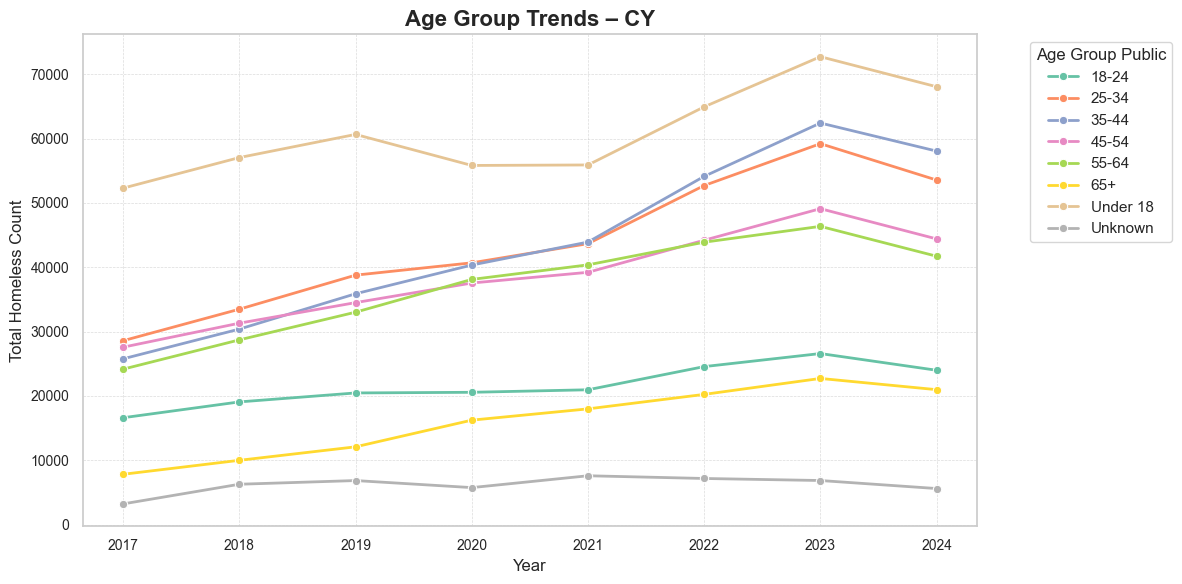

✅ Plot saved to: ../outputs/plots/age_trend_12mo.png


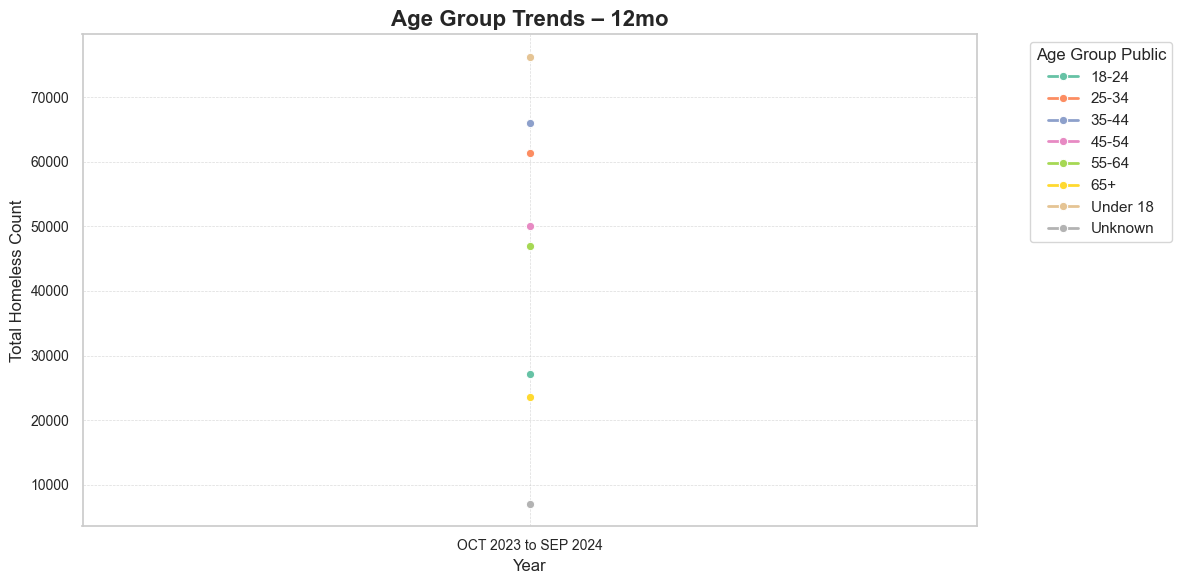

✅ Plot saved to: ../outputs/plots/gender_trend_cy.png


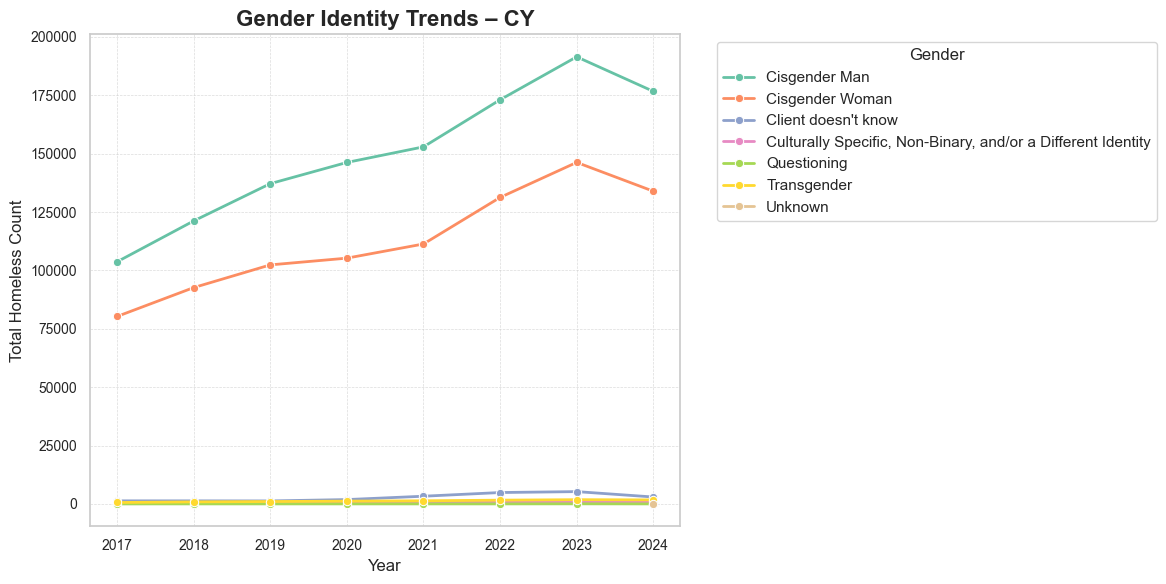

✅ Plot saved to: ../outputs/plots/gender_trend_12mo.png


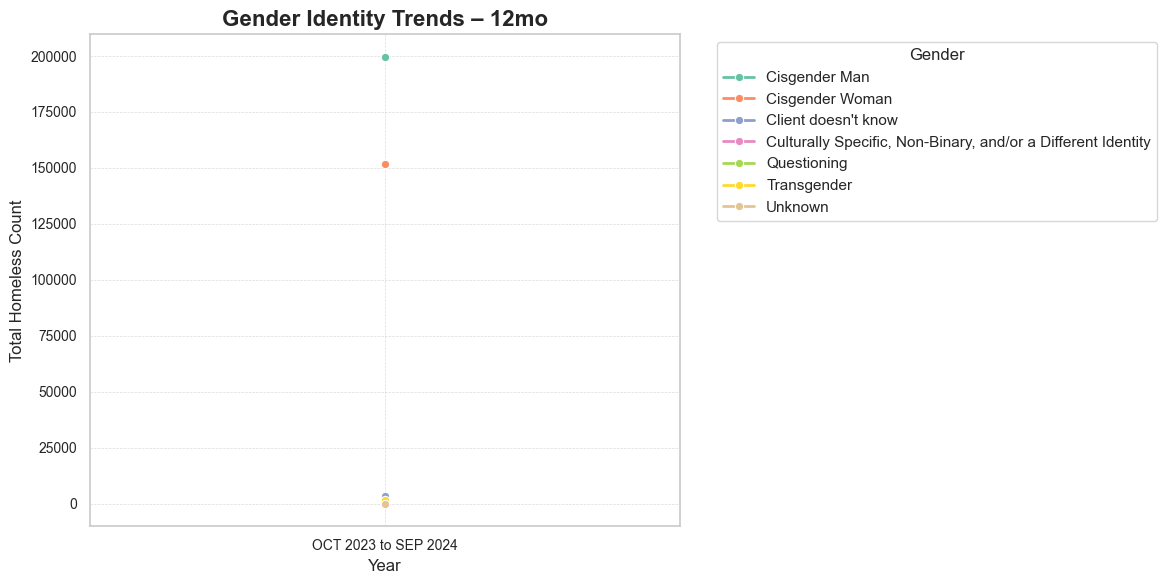

✅ Plot saved to: ../outputs/plots/race_trend_cy.png


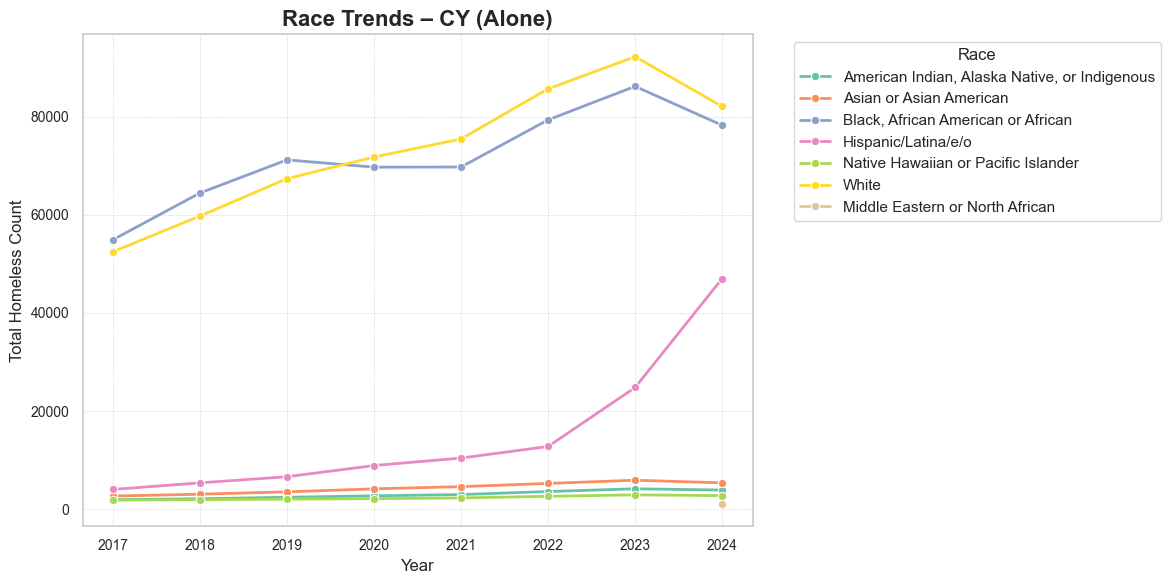

✅ Plot saved to: ../outputs/plots/race_trend_12mo.png


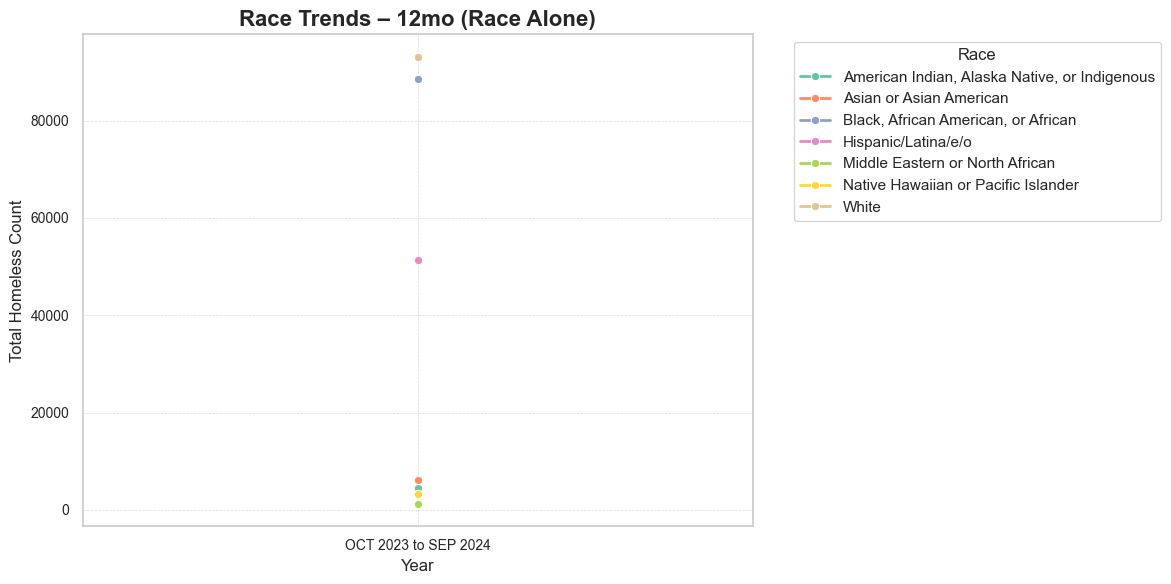

In [ ]:

plot_trend(age_cy_clean, "AGE_GROUP_PUBLIC", "Age Group Trends – CY", "age_trend_cy")
plot_trend(age_12mo_clean, "AGE_GROUP_PUBLIC", "Age Group Trends – 12mo", "age_trend_12mo")
plot_trend(gender_cy_clean, "GENDER", "Gender Identity Trends – CY", "gender_trend_cy")
plot_trend(gender_12mo_clean, "GENDER", "Gender Identity Trends – 12mo", "gender_trend_12mo")
plot_trend(race_cy_filtered, "RACE", "Race Trends – CY (Alone)", "race_trend_cy")
plot_trend(race_12mo_filtered, "RACE", "Race Trends – 12mo (Race Alone)", "race_trend_12mo")




Hospital Burden Analysis by County

✅ Plot saved to: ../outputs/plots/hospital_utilization_proxy.png


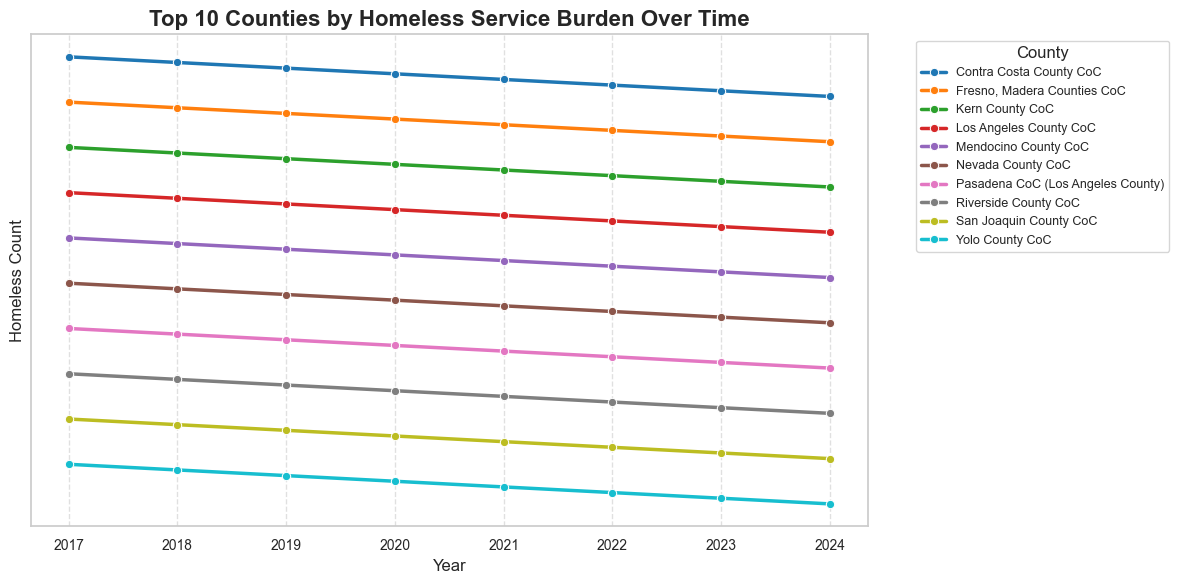

In [ ]:
data = age_cy_clean.groupby(["LOCATION", "CALENDAR_YEAR"])["HOMELESS_COUNT"].sum().reset_index()
latest_year = data["CALENDAR_YEAR"].max()
top_counties = data[data["CALENDAR_YEAR"] == latest_year].sort_values("HOMELESS_COUNT", ascending=False).head(10)["LOCATION"].tolist()

def plot_service_burden(df, county_list):
    top_df = df[df["LOCATION"].isin(county_list)]
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(data=top_df, x="CALENDAR_YEAR", y="HOMELESS_COUNT", hue="LOCATION", marker="o", linewidth=2.5, palette="tab10", ax=ax)
    ax.set_title("Top 10 Counties by Homeless Service Burden Over Time", fontsize=16, weight="bold")
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Homeless Count", fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(range(int(y_min), int(y_max) + 1, 5000))
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title="County", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
    fig.tight_layout()
    output_path = "../outputs/plots/hospital_utilization_proxy.png"
    fig.savefig(output_path, dpi=300)
    print(f"✅ Plot saved to: {output_path}")
    plt.show()

plot_service_burden(data, top_counties)




In [7]:
### 🔹 Cell 7: Q6 – System Performance Trends (Gender & Age)
# Gender
gender_recent = gender_cy_clean[gender_cy_clean["CALENDAR_YEAR"] >= 2020].copy()
gender_recent["HOMELESS_COUNT"] = pd.to_numeric(gender_recent["HOMELESS_COUNT"], errors="coerce")
gender_recent = gender_recent[gender_recent["HOMELESS_COUNT"] < 100000]
gender_trend = gender_recent.groupby(["CALENDAR_YEAR", "GENDER"])["HOMELESS_COUNT"].sum().reset_index()
gender_trend.loc[gender_trend["HOMELESS_COUNT"] == 0, "HOMELESS_COUNT"] = np.nan
gender_trend["YOY_CHANGE"] = gender_trend.groupby("GENDER")["HOMELESS_COUNT"].pct_change(fill_method=None) * 100
gender_trend["YOY_CHANGE"] = gender_trend["YOY_CHANGE"].clip(-500, 500)
gender_trend = gender_trend.dropna(subset=["YOY_CHANGE"])

# Age
age_recent = age_cy_clean[age_cy_clean["CALENDAR_YEAR"] >= 2020].copy()
age_recent["HOMELESS_COUNT"] = pd.to_numeric(age_recent["HOMELESS_COUNT"], errors="coerce")
age_recent_clean = age_recent[age_recent["HOMELESS_COUNT"] < 100000]
age_trend = age_recent_clean.groupby(["CALENDAR_YEAR", "AGE_GROUP_PUBLIC"])["HOMELESS_COUNT"].sum().reset_index()
age_trend.loc[age_trend["HOMELESS_COUNT"] == 0, "HOMELESS_COUNT"] = np.nan
age_trend["YOY_CHANGE"] = age_trend.groupby("AGE_GROUP_PUBLIC")["HOMELESS_COUNT"].pct_change(fill_method=None) * 100
age_trend["YOY_CHANGE"] = age_trend["YOY_CHANGE"].clip(-500, 500)
age_trend = age_trend.dropna(subset=["YOY_CHANGE"])




✅ Plot saved to: ../outputs/plots/system_yoy_gender_change.png


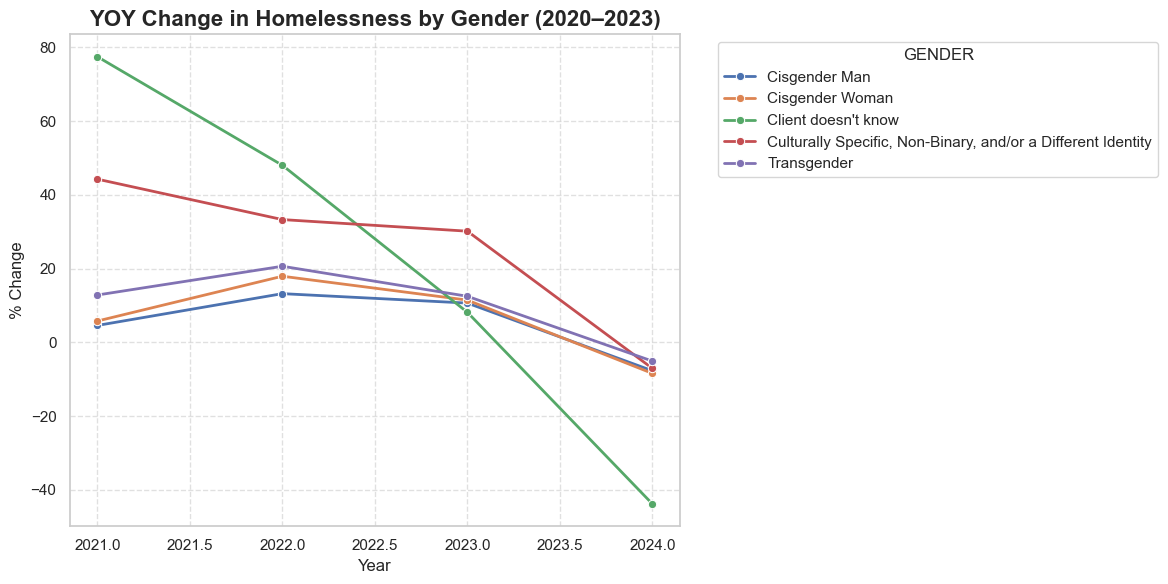

✅ Plot saved to: ../outputs/plots/system_yoy_age_change.png


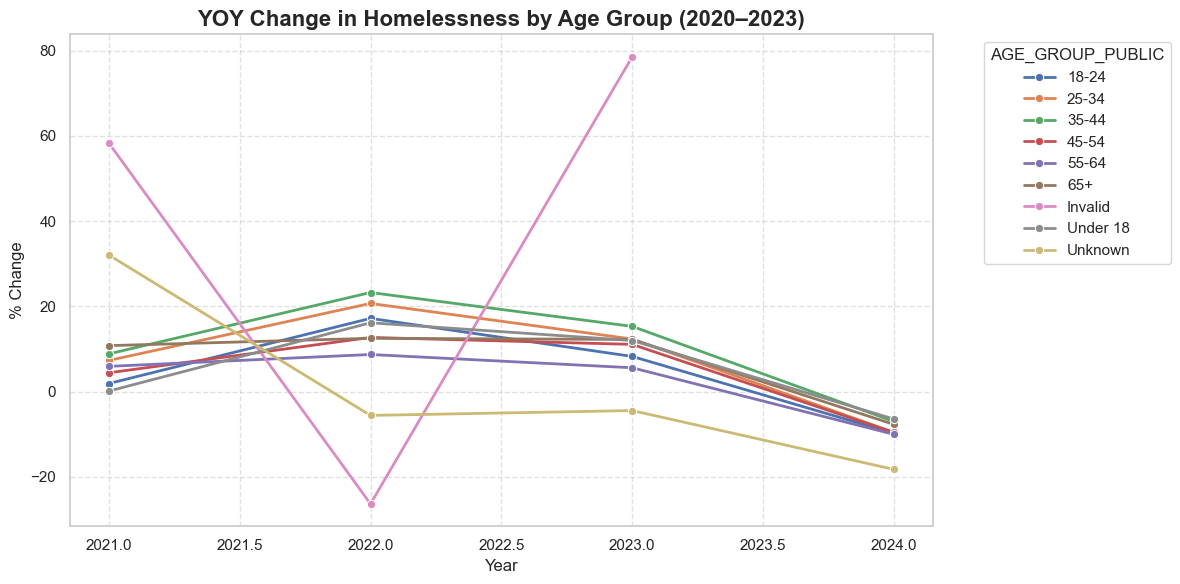

In [8]:
### 🔹 Cell 8: Define YOY Change Plot Function
def plot_yoy_change(df, group_col, title, filename):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x="CALENDAR_YEAR", y="YOY_CHANGE", hue=group_col, marker="o", linewidth=2)
    plt.title(title, fontsize=16, weight="bold")
    plt.xlabel("Year")
    plt.ylabel("% Change")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title=group_col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    path = f"../outputs/plots/{filename}.png"
    plt.savefig(path, dpi=300)
    print(f"✅ Plot saved to: {path}")
    plt.show()

plot_yoy_change(gender_trend, group_col="GENDER", title="YOY Change in Homelessness by Gender (2020–2023)", filename="system_yoy_gender_change")
plot_yoy_change(age_trend, group_col="AGE_GROUP_PUBLIC", title="YOY Change in Homelessness by Age Group (2020–2023)", filename="system_yoy_age_change")